# clasificación de texturas

In [1]:
import numpy as np
import cv2   as cv

import matplotlib.pyplot as plt
%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

## Local Binary Patterns

Emplearemos el descriptor de textura [LBP](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html).

In [2]:
from skimage.feature import local_binary_pattern

Lo probamos en cualquier imagen:

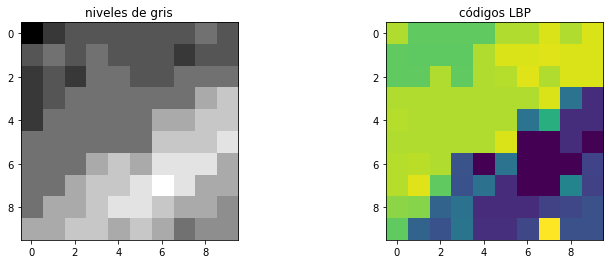

In [3]:
img = rgb2gray(readrgb('coins.png'))

lbp = local_binary_pattern(img,8,5)

fig(12,4)
plt.subplot(1,2,1)
plt.imshow(img[300:310,300:310],'gray', interpolation='nearest')
plt.title('niveles de gris')
plt.subplot(1,2,2)
plt.imshow(lbp[300:310,300:310],interpolation='nearest')
plt.title('códigos LBP');

Son códigos binarios para cada posible configuración de entornos de pixel 3x3, teniendo en cuenta si cada pixel es más o menos oscuro que el centro.

In [4]:
lbp[:5,:5]

array([[ 193.,  193.,  193.,  193.,   97.],
       [ 193.,  193.,   65.,   65.,   96.],
       [ 193.,   64.,   64.,   64.,   96.],
       [ 192.,   64.,    0.,    0.,   96.],
       [ 192.,    0.,    0.,   64.,   32.]])

La "textura" de una región de la imagen (o de toda ella) se puede describir mediante un histograma de estos códigos.

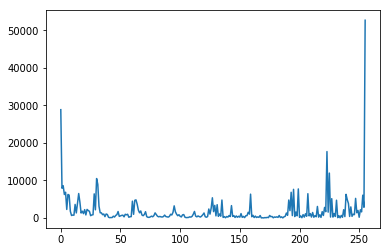

In [5]:
hlbp, _b = np.histogram(lbp, bins=np.arange(257))
plt.plot(hlbp);

Creamos una función con las operaciones anteriores:

In [6]:
# calcula el código LBP de cada pixel y hace un histograma de ellos
def feature(x):
    g = rgb2gray(x)
    h,w = g.shape
    lbp = local_binary_pattern(g,8,5)
    d = 10  # descartamos un borde de 10 pixels
    h,b = np.histogram(lbp[d:-d,d:-d], bins=256, range=(0,256))
    s = np.sum(h)
    return h/s

En primer lugar experimentamos con una pequeña colección de imágenes de texturas:

    wget https://robot.inf.um.es/material/va/texturas.tar.gz
    
(En la carpeta `images/texturas` del repositorio hay un script que automatiza la descarga).

Como no son muchas imágenes podemos guardarlas todas en una lista:

In [7]:
import glob

texs = [ (file, readrgb(file)) for file in glob.glob('../images/texturas/simple/*.*') ]

In [8]:
len(texs)

59

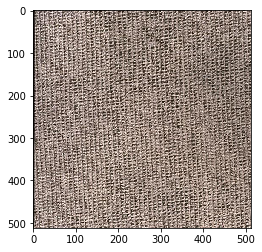

In [9]:
plt.imshow(texs[0][1]);

In [10]:
vs = [feature(t[1]) for t in texs]

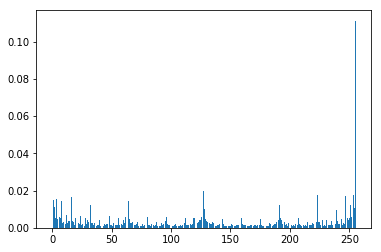

In [11]:
plt.bar(range(256),vs[23]);

La siguiente función encuentra las imágenes más parecidas a una de ellas.

In [12]:
import numpy.linalg as la

# dado un elemento k, busca el más parecido en la lista, (que no sea él mismo)
def check(k,vs):
    vk = vs[k]
    ds = [ (la.norm(v-vk), m) for m,v in enumerate(vs) if m != k ]
    return sorted(ds)

[(0.0, 38),
 (0.0099395149758612755, 34),
 (0.0099395149758612755, 40),
 (0.013524014877924262, 27),
 (0.013524014877924262, 55)]

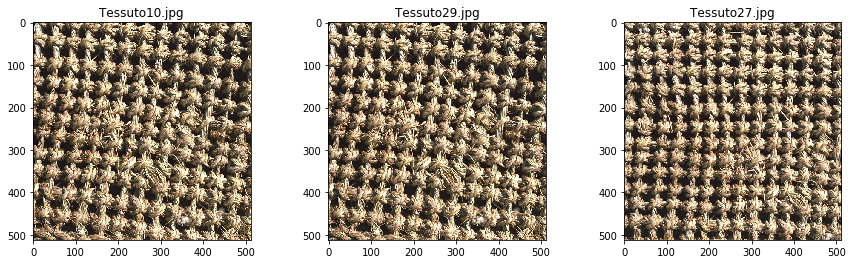

In [13]:
t = 8
r = check(t,vs)[:5]

y = r[0][1]
z = r[1][1]
fig(15,4)
plt.subplot(1,3,1); plt.imshow(texs[t][1]); plt.title(texs[t][0][26:]);
plt.subplot(1,3,2); plt.imshow(texs[y][1]); plt.title(texs[y][0][26:]);
if r[0][0] == 0:
    plt.subplot(1,3,3); plt.imshow(texs[z][1]); plt.title(texs[z][0][26:]);

r

Hay imágenes repetidas. Vamos a utilizar una colección de texturas más completa:

    wget https://robot.inf.um.es/material/va/curetgrey.zip

En este caso guardamos directamente la "feature" para no tener en memoria las 5.6K imágenes de la colección. (Pero entonces luego habrá que leer otra vez con `readrgb` las imágenes que queramos mostrar.)

In [14]:
# no es instantáneo...
texs = [ (file, feature(readrgb(file))) for file in glob.glob('../images/texturas/curetgrey/*/*.*') ]

In [15]:
len(texs)

5612

In [16]:
vs = [t[1] for t in texs]

[(0.0073683383264915477, 2388),
 (0.0087924509680350812, 2310),
 (0.010010948891015356, 2353),
 (0.010027587309006594, 2342),
 (0.011632240670429082, 3442)]

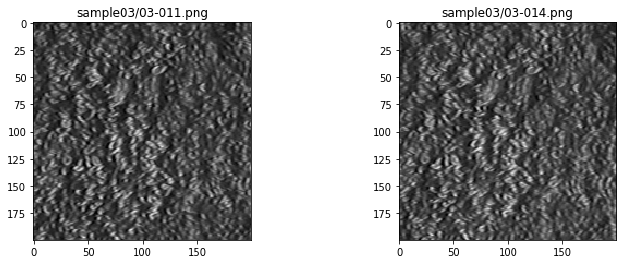

In [17]:
t = 2345
r = check(t,vs)[:5]

y = r[0][1]

fig(12,4)
plt.subplot(1,2,1); plt.imshow(readrgb(texs[t][0])); plt.title(texs[t][0][29:]);
plt.subplot(1,2,2); plt.imshow(readrgb(texs[y][0])); plt.title(texs[y][0][29:]);

r